# ROOT4J/Spark-Root: ROOT I/O for JVM and Applications for Apache Spark

```
for pyspark:
pyspark --packages org.diana-hep:spark-root_2.11:0.1.7,org.diana-hep:histogrammar-sparksql_2.11:1.0.3 --conf spark.dynamicAllocation.enabled=false --executor-cores 4 --num-executors 60 --master yarn --py-files /afs/cern.ch/user/v/vkhriste/public/histogrammar-1.0.6.zip 

for scala:
spark-shell --packages org.diana-hep:spark-root_2.11:0.1.7,org.diana-hep:histogrammar-sparksql_2.11:1.0.3 --conf spark.dynamicAllocation.enabled=false --executor-cores 4 --num-executors 60 --master yarn
```

## Motivation
- Enable access to Physics Data from SPARK.
- ROOT Data Format is, almost, self-descriptive -> JVM-based I/O is therefore a realistic goal!
- Open up ROOT for the use with Big Data Platforms (Spark is just a single example)

## What spark-root is
- ROOT I/O Library for JVM
- purely Scala/Java based
- a new Spark Data Source, like Parquet/Avro

## Supported Datatypes
- Basic Types: Integer, Boolean, Float, ...
- Arrays, 1/N-dim, fixed/var-size arrays
- Pointers to basic Types
- Structs in MultiLeaf style
- STL Collections. Nested STL collections of basic types ```std::map<int, std::vector<float> >```
- Composite Classes, Nested Composite Classes ``` class A{}; class B { ... A a; ...};```
- STL Collections of Composites. Multi-level hierarchy is supported
- TClonesArray

## Some Functionality
- Automatic Spark Schema Inferral
- HDFS Support (w/o Data Locality yet!)
- Early Stage Filtering

In [4]:
sc.defaultParallelism

240

In [5]:
df = sqlContext.read.format("org.dianahep.sparkroot").option("tree", "Events").load("hdfs:/cms/bigdatasci/vkhriste/data/publiccms_muionia_aod")
#df1 = sqlContext.read.format("org.dianahep.sparkroot").option("tree", "Events").load("hdfs:/cms/bigdatasci/vkhriste/data/publiccms_muionia_aod/0000/FEEFB039-0978-E011-BB60-E41F131815BC.root")
df.printSchema()

root
 |-- EventAuxiliary: struct (nullable = true)
 |    |-- processHistoryID_: struct (nullable = true)
 |    |    |-- hash_: string (nullable = true)
 |    |-- id_: struct (nullable = true)
 |    |    |-- run_: integer (nullable = true)
 |    |    |-- luminosityBlock_: integer (nullable = true)
 |    |    |-- event_: integer (nullable = true)
 |    |-- processGUID_: string (nullable = true)
 |    |-- time_: struct (nullable = true)
 |    |    |-- timeLow_: integer (nullable = true)
 |    |    |-- timeHigh_: integer (nullable = true)
 |    |-- luminosityBlock_: integer (nullable = true)
 |    |-- isRealData_: boolean (nullable = true)
 |    |-- experimentType_: integer (nullable = true)
 |    |-- bunchCrossing_: integer (nullable = true)
 |    |-- orbitNumber_: integer (nullable = true)
 |    |-- storeNumber_: integer (nullable = true)
 |-- EventBranchEntryInfo: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- branchID_: struct (nullable = true)
 

In [6]:
df.count()

12058887

In [7]:
slimmedEvents = df.select("recoMuons_muons__RECO_.recoMuons_muons__RECO_obj.reco::RecoCandidate.reco::LeafCandidate")
slimmedEvents.printSchema()


root
 |-- reco::LeafCandidate: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- reco::Candidate: struct (nullable = true)
 |    |    |-- qx3_: integer (nullable = true)
 |    |    |-- pt_: float (nullable = true)
 |    |    |-- eta_: float (nullable = true)
 |    |    |-- phi_: float (nullable = true)
 |    |    |-- mass_: float (nullable = true)
 |    |    |-- vertex_: struct (nullable = true)
 |    |    |    |-- fCoordinates: struct (nullable = true)
 |    |    |    |    |-- fX: float (nullable = true)
 |    |    |    |    |-- fY: float (nullable = true)
 |    |    |    |    |-- fZ: float (nullable = true)
 |    |    |-- pdgId_: integer (nullable = true)
 |    |    |-- status_: integer (nullable = true)
 |    |    |-- cachePolarFixed_: struct (nullable = true)
 |    |    |-- cacheCartesianFixed_: struct (nullable = true)



In [8]:
slimmedEvents.show()

+--------------------+
| reco::LeafCandidate|
+--------------------+
|[[[],-3,3.085807,...|
|[[[],3,4.1558356,...|
|[[[],-3,3.8067229...|
|[[[],3,2.4893947,...|
|[[[],-3,4.5430374...|
|[[[],-3,3.1356623...|
|[[[],-3,2.1504705...|
|[[[],-3,3.2125602...|
|[[[],3,4.3416142,...|
|[[[],-3,2.1879413...|
|[[[],3,5.258412,-...|
|[[[],3,5.627528,2...|
|[[[],-3,3.8034406...|
|[[[],3,2.0771139,...|
|[[[],-3,3.891133,...|
|[[[],-3,5.891902,...|
|[[[],3,2.226252,2...|
|[[[],-3,6.2603984...|
|[[[],3,1.8396659,...|
|[[[],3,1.7337813,...|
+--------------------+
only showing top 20 rows



In [9]:
from math import *
import numpy
from pyspark.sql import Row

In [10]:
def invariantMass(muon1, muon2):
    pt1 = abs(muon1.pt_)
    phi1 = muon1.phi_
    theta1 = 2.0*atan(exp(-muon1.eta_))
    px1 = pt1 * cos(phi1)
    py1 = pt1 * sin(phi1)
    pz1 = pt1 / tan(theta1)
    E1 = sqrt(px1**2 + py1**2 + pz1**2 + 0.10565836727619171**2)
    #
    pt2 = abs(muon2.pt_)
    phi2 = muon2.phi_
    theta2 = 2.0*atan(exp(-muon2.eta_))
    px2 = pt2 * cos(phi2)
    py2 = pt2 * sin(phi2)
    pz2 = pt2 / tan(theta2)
    E2 = sqrt(px2**2 + py2**2 + pz2**2 + 0.10565836727619171**2)
    #
    return sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
def handleEvent(event):
    # decreasing order of muon pT
    sortedMuons = sorted(event[0], key=lambda muon: -muon.pt_)
    if len(sortedMuons) < 2:
        return []
    else:
        muon1, muon2 = sortedMuons[:2]
        # return [Row(mass=invariantMass(muon1, muon2), pt1=muon1.pt_, phi1=muon1.phi_, eta1=muon1.eta_, pt2=muon2.pt_, phi2=muon2.phi_, eta2=muon2.eta_)]
        return [invariantMass(muon1, muon2)]

In [11]:
# 
# doing toDF.persist directly is not working
# http://stackoverflow.com/questions/32742004/create-spark-dataframe-can-not-infer-schema-for-type-type-float/32742294
#
dimuon_masses = slimmedEvents.rdd.flatMap(handleEvent).map(lambda x: (x, )).toDF().persist()

In [12]:
from histogrammar import *

#from primitives.bin import Bin

empty = Bin(100, 0, 10, lambda x: x._1)
filled = dimuon_masses.rdd.aggregate(empty, increment, combine)

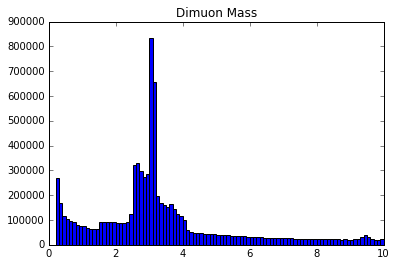

In [13]:
%matplotlib inline
filled.plot.matplotlib(name="Dimuon Mass")

Welcome to JupyROOT 6.09/01


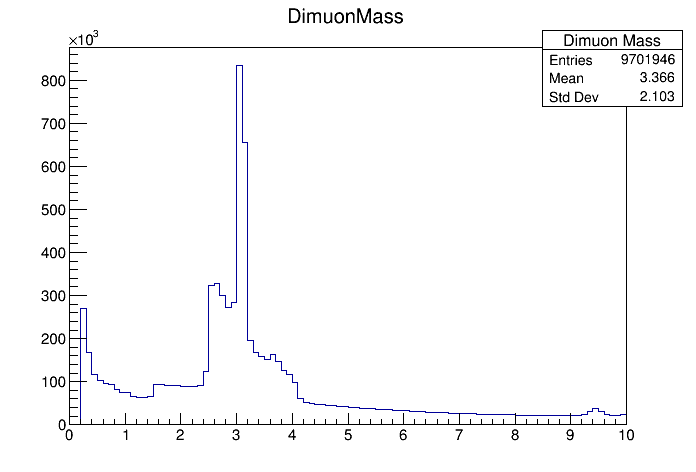

In [15]:
import ROOT
hist = filled.plot.root("Dimuon Mass", "DimuonMass")
c = ROOT.TCanvas("c")
hist.Draw()
c.Draw()

In [18]:
df2 = sqlContext.read.format("org.dianahep.sparkroot").load("hdfs:/cms/bigdatasci/vkhriste/data/higgs")
df2.printSchema()


root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- analysis::core::Track: struct (nullable = true)
 |    |    |    |-- analysis::core::Object: struct (nullable = true)
 |    |    |    |-- _charge: integer (nullable = true)
 |    |    |    |-- _pt: float (nullable = true)
 |    |    |    |-- _pterr: float (nullable = true)
 |    |    |    |-- _eta: float (nullable = true)
 |    |    |    |-- _phi: float (nullable = true)
 |    |    |-- _isTracker: boolean (nullable = true)
 |    |    |-- _track: struct (nullable = true)
 |    |    |    |-- analysis::core::Object: struct (nullable = true)
 |    |    |    |-- _charge: integer (nullable = true)
 |    |    |    |-- _pt: float (nullable = true)
 |    |    |    |-- _pterr: float (nullable = true)
 |    |    |    |-- _eta: float (nullable = true)
 |    |    |    |-- _phi: float (nullable = true)
 |    |    |-- _isStandAlone: boolean (nullable = true)
 |    |    |-- _isGlobal: boolean (nullab

In [19]:
df2.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+
|               Muons|                Jets|            Vertices|               Event|      EventAuxiliary|                 MET|Electrons|                Taus|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+
|[[[[],1,26.159414...|[[[],16.058462,24...|[[[],1,0.06512373...|[273730,419,46628...|[0,0,WrappedArray...|[-7.171677,-11.49...|       []|[[[[],1,26.159414...|
|[[[[],1,45.94085,...|[[[],50.366344,-1...|[[[],1,0.06391791...|[273730,419,46638...|[0,0,WrappedArray...|[3.0971017,3.4679...|       []|[[[[],1,45.94085,...|
|[[[[],-1,27.60417...|[[[],43.882526,8....|[[[],1,0.06500953...|[273730,419,46619...|[0,0,WrappedArray...|[-3.3979132,25.28...|       []|[[[[],1,31.418518...|
|[[[[],1,32.804413...|[[[],-6.798022,-4...|[[[